# Introduction: PUMS home value analysis

I am analyzing the 2011-2015 PUMS housing data, found [here](https://www.census.gov/programs-surveys/acs/data/pums.html). The data dictionary which explains the meaning of each column and the values contained within is available [here.](https://www.census.gov/programs-surveys/acs/technical-documentation/pums/documentation.2015.html) I want to find an algorithm that can predict the value of the home.

## Part I: Importing the data

We will start by importing some libraries very useful for machine learning including pandas and scikit-learn. It will be helpful to change the column names to be more readable. I have chosen to use data from two states with very low populations (North Dakota and Wyoming) and two states with very high populations (New York and Texas) to get a fairly diverse dataset.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import linear_model
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor

In [2]:
dat = pd.concat([pd.read_csv('ss15hnd.csv'), pd.read_csv('ss15hny.csv'),
                 pd.read_csv('ss15hwy.csv'),
                 pd.read_csv('ss15htx.csv')], ignore_index = True)
dat.rename(columns = {"insp": "INSP"}, inplace = True)

In [3]:
colnames = ["ST", "NP", "ACR", "BATH", "BDSP", "ELEP", "GASP", "INSP",
              "RMSP", "RWAT", "SINK", "VALP", "VEH", "WATP", "YBL", "HINCP"]
readable_names = ["State", "Num_People", "Lot_Size", "Has_Bathtub", "Num_Bedrooms",
                  "Monthly_Electric", "Monthly_Gas", "Yearly_Insurance_Cost", "Num_Rooms",
                  "Has_Hot_Water", "Has_Sink", "Price", "Num_Vehicles",
                  "Yearly_Water", "Year_Built", "Household_Income"]

cols = dat[colnames]

cols.columns = readable_names

cols.dropna(inplace = True)
cols.describe()

/Users/hunter/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,State,Num_People,Lot_Size,Has_Bathtub,Num_Bedrooms,Monthly_Electric,Monthly_Gas,Yearly_Insurance_Cost,Num_Rooms,Has_Hot_Water,Has_Sink,Price,Num_Vehicles,Yearly_Water,Year_Built,Household_Income
count,533806.000000,533806.000000,533806.000000,533806.000000,533806.000000,533806.000000,533806.000000,533806.000000,533806.000000,533806.000000,533806.000000,5.338060e+05,533806.000000,533806.000000,533806.000000,5.338060e+05
mean,43.506506,2.642762,1.293528,1.001973,3.209711,173.745224,57.339342,1072.360419,6.774317,1.002823,1.001907,2.370636e+05,2.032564,526.212000,5.122936,9.340733e+04
std,5.993857,1.461454,0.566703,0.044370,0.940672,105.178184,81.880871,1030.062644,2.223480,0.053058,0.043628,3.416026e+05,1.005941,558.325665,3.057706,9.722710e+04
min,36.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000e+02,0.000000,1.000000,1.000000,-1.680000e+04
25%,36.000000,2.000000,1.000000,1.000000,3.000000,100.000000,3.000000,450.000000,5.000000,1.000000,1.000000,8.000000e+04,1.000000,70.000000,3.000000,3.670000e+04
50%,48.000000,2.000000,1.000000,1.000000,3.000000,150.000000,30.000000,900.000000,6.000000,1.000000,1.000000,1.500000e+05,2.000000,400.000000,5.000000,6.900000e+04
75%,48.000000,4.000000,1.000000,1.000000,4.000000,230.000000,80.000000,1400.000000,8.000000,1.000000,1.000000,2.800000e+05,3.000000,800.000000,7.000000,1.150200e+05
max,56.000000,20.000000,3.000000,2.000000,12.000000,650.000000,570.000000,8100.000000,22.000000,2.000000,2.000000,5.216000e+06,6.000000,3600.000000,19.000000,2.090000e+06


## Part II: Data Wrangling

We now have 16 features and a target column ("Price") with just over 400,000 observations. We will need to clean the data a little further. The next cell will separate the state column into four columns representing each state a method for representing categorical variables known as one-hot encoding.

In [4]:
cols = pd.get_dummies(cols, columns = ["State"])
readable_names = readable_names[1:]
states =["NY", "ND", "TX", "WY"]
readable_names.extend(states)
cols.columns = readable_names

The documentation tells us that some of the values in the year built column correspond to a year and some of them a range of years. We want to change it to the age of the house in years since it is a more reasonable range to work with. For values corresponding to a range I have put the age in the midpoint of the range.

In [5]:
ybl = cols.Year_Built

ybl.loc[ybl == 1.0] = 90
ybl.loc[ybl == 2.0] = 70
ybl.loc[ybl == 3.0] = 60
ybl.loc[ybl == 4.0] = 50
ybl.loc[ybl == 5.0] = 40
ybl.loc[ybl == 6.0] = 30
ybl.loc[ybl == 7.0] = 20
ybl.loc[ybl == 8.0] = 13
ybl.loc[ybl == 9.0] = 10
ybl.loc[ybl == 10.0] = 9
ybl.loc[ybl == 11.0] = 8
ybl.loc[ybl == 12.0] = 7
ybl.loc[ybl == 13.0] = 6
ybl.loc[ybl == 14.0] = 5
ybl.loc[ybl == 15.0] = 4
ybl.loc[ybl == 16.0] = 3
ybl.loc[ybl == 17.0] = 2
ybl.loc[ybl == 18.0] = 1
ybl.loc[ybl == 19.0] = 0
ybl.head()

/Users/hunter/anaconda/lib/python3.6/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


0     60.0
5     40.0
12    60.0
13    30.0
15    90.0
Name: Year_Built, dtype: float64

In [6]:
cols.rename(columns={"Year_Built":"Age"}, inplace = True)

The columns 'ADJHSG' and 'ADJINC' in the original dataset adjust monetary values in each record for inflation. We will want to adjust the data accordingly so that each record is given in 2015 dollars.

In [7]:
for col in ["Monthly_Electric", "Monthly_Gas", "Yearly_Insurance_Cost", "Yearly_Water"]:
    cols.loc[:,col] *= dat.loc[cols.index, 'ADJHSG'] * 10**-6
    
cols.Household_Income *= dat.loc[cols.index, 'ADJINC'] * 10**-6

Next we will add a column to flag whether or not the home is a mobile home.

In [8]:
cols['Mobile_Home'] = pd.Series(dat.BLD == 1, dtype = 'int')

## Part III: Exploratory Analysis and Regression Pass 1

Many machine learning algorithms are improved by normalizing the input data. scikit-learn has a handy function to do this. First we will want to separate the features from our target column.

In [9]:
cols.reset_index(drop=True, inplace=True)
Y = cols.Price
X_names = [c for c in cols.columns if c != "Price"]
X = cols[X_names]

In [10]:
X = pd.DataFrame(preprocessing.minmax_scale(X))
X.columns = X_names
X.describe()

,Num_People,Lot_Size,Has_Bathtub,Num_Bedrooms,Monthly_Electric,Monthly_Gas,Yearly_Insurance_Cost,Num_Rooms,Has_Hot_Water,Has_Sink,Num_Vehicles,Yearly_Water,Age,Household_Income,NY,ND,TX,WY,Mobile_Home
count,533806.000000,533806.000000,533806.000000,533806.000000,533806.000000,533806.000000,533806.000000,533806.000000,533806.000000,533806.000000,533806.000000,533806.000000,533806.000000,533806.000000,533806.000000,533806.000000,533806.000000,533806.000000,533806.000000
mean,0.086461,0.146764,0.001973,0.267476,0.271672,0.101124,0.134827,0.274967,0.002823,0.001907,0.338761,0.141327,0.477740,0.052461,0.367679,0.021238,0.594705,0.016379,0.067195
std,0.076919,0.283352,0.044370,0.078389,0.165372,0.146936,0.129204,0.105880,0.053058,0.043628,0.167657,0.150205,0.294280,0.046167,0.482174,0.144177,0.490950,0.126927,0.250359
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.052632,0.000000,0.000000,0.250000,0.152720,0.003607,0.056012,0.190476,0.000000,0.000000,0.166667,0.019186,0.222222,0.025497,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.052632,0.000000,0.000000,0.250000,0.233637,0.051027,0.112929,0.238095,0.000000,0.000000,0.333333,0.108603,0.444444,0.040725,0.000000,0.000000,1.000000,0.000000,0.000000
75%,0.157895,0.000000,0.000000,0.333333,0.353258,0.139002,0.178220,0.333333,0.000000,0.000000,0.500000,0.214352,0.666667,0.063016,1.000000,0.000000,1.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Let's split the data into training and testing sets and see how a simple linear regression performs to get a sense of how difficult this problem might be.

In [12]:
#split into test and train
ttsplit = model_selection.train_test_split
X_train, X_test, y_train, y_test = ttsplit(X, Y, test_size = 0.3, random_state = 4)
#the random state here is chosen explicitly so that the code is reproducible

In [13]:
%%time

lm = linear_model.LinearRegression()
lm.fit(X_train, y_train)

CPU times: user 994 ms, sys: 143 ms, total: 1.14 s
Wall time: 2.19 s


In [14]:
%%time

lm.score(X_test, y_test)

CPU times: user 59.5 ms, sys: 5.64 ms, total: 65.1 ms
Wall time: 91.4 ms


0.38254921583202128

The linear classifier is performing poorly, at less than 40% accurate. In order to see where the problem is, I want to see if there is some group of observations with poor predictability. We will partition the homes by price into extremely low priced (< 10,000 USD), low priced (10,000-99,999 USD), medium priced (100,000-499,999 USD), and high priced (> 500,000 USD).

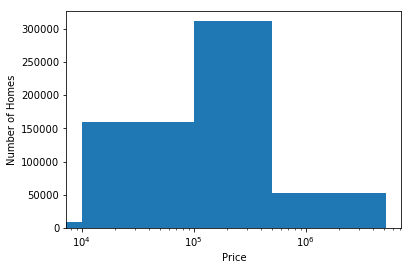

In [16]:
%matplotlib inline

plt.hist(Y, bins=[100,10000,100000,500000,max(Y)])
plt.xlabel("Price")
plt.ylabel("Number of Homes")
plt.xscale('log')

The number of homes priced at less than $10,000 is significant, at almost 2 percent of the data (see next cell). I first want to see if these homes have any predictability or if they are possibly reported erroneously. Since set of extremely low prices is quite small in proportion to the total dataset I am undersampling the larger class.

In [18]:
sum(Y < 10000)/len(Y)

0.017779867592346284

In [19]:
ythis = Y[Y < 10000].copy()
ythis = pd.concat([ythis, y_train[y_train >= 10000].head(len(ythis)).copy()])
ythis[ythis < 10000] = 1
ythis[ythis > 1] = 0

xthis = X.loc[ythis.index, :]

#train/test split
xtrainthis, xtestthis, ytrainthis, ytestthis= ttsplit(xthis,
                                                      ythis,
                                                      test_size = .3,
                                                      random_state=4)
clf = RandomForestClassifier(n_estimators = 50, n_jobs = -1)
clf.fit(xtrainthis, ytrainthis)
clf.score(xtestthis, ytestthis)

0.91360842844600532

In [20]:
cols.loc[cols.Price < 10000, states].describe()

,NY,ND,TX,WY
count,9491.000000,9491.000000,9491.000000,9491.000000
mean,0.293014,0.036982,0.640080,0.029923
std,0.455169,0.188729,0.480002,0.170384
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,1.000000,0.000000
75%,1.000000,0.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000


Apparently there is a relatively large level of predictability with the extremely low priced homes, with a correct classification 91.4% of the time. The extremely low priced observations also do not appear to be concentrated in any one state. Compare the distribution of extremely low priced homes above with the next cell showing distribution of all records.

In [21]:
cols.loc[:,states].describe()

,NY,ND,TX,WY
count,533806.000000,533806.000000,533806.000000,533806.000000
mean,0.367679,0.021238,0.594705,0.016379
std,0.482174,0.144177,0.490950,0.126927
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,1.000000,0.000000
75%,1.000000,0.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000


Let's look at how well we can predict low (< 100,000 USD), medium (100,000-500,000 USD), and high (> 500,000 USD) priced homes.

In [22]:
ythis = Y[Y < 100000].copy()
ythis = pd.concat([ythis, y_train[y_train >= 100000].head(len(ythis)).copy()])
ythis[ythis < 100000] = 1
ythis[ythis > 1] = 0

xthis = X.loc[ythis.index, :]

xtrainthis, xtestthis, ytrainthis, ytestthis= ttsplit(xthis,
                                                      ythis,
                                                      test_size = .3,
                                                      random_state=4)
clf = RandomForestClassifier(n_estimators = 50, n_jobs = -1)
clf.fit(xtrainthis, ytrainthis)
clf.score(xtestthis, ytestthis)

0.81759582738768888

The low priced homes are correctly classified approximately 81% of the time.

The majority of the homes are between \$100,000 and \$500,000. We will not want to undersample here.

In [23]:
ythis = y_train.copy()
ythis[(ythis>=100000) & (ythis<500000)] = 1
ythis[ythis > 1] = 0

xthis = X_train.loc[ythis.index, :]

xtrainthis, xtestthis, ytrainthis, ytestthis= ttsplit(xthis,
                                                      ythis,
                                                      test_size = .3,
                                                      random_state=4)
clf = RandomForestClassifier(n_estimators = 50, n_jobs = -1)
clf.fit(xtrainthis, ytrainthis)
clf.score(xtestthis, ytestthis)

0.76064228367528997

Finally, we will want to test how well we can predict homes priced over $500,000.

In [24]:
ythis = Y[Y >= 500000].copy()
ythis = pd.concat([ythis, y_train[y_train < 500000].head(len(ythis)).copy()])
ythis[ythis >= 500000] = 1
ythis[ythis > 1] = 0

xthis = X.loc[ythis.index, :]

xtrainthis, xtestthis, ytrainthis, ytestthis= ttsplit(xthis,
                                                      ythis,
                                                      test_size = .3,
                                                      random_state=4)

clf = RandomForestClassifier(n_estimators = 50, n_jobs = -1)
clf.fit(xtrainthis, ytrainthis)
clf.score(xtestthis, ytestthis)

0.83437836468427384

Apparently all of our classes are fairly predictable, as the classifier was able to score all classes accurately.

## Part IV: Regression Pass 2

Now that we know each of our classes is relatively predictable we will see if possibly the problem is our algorithm. The linear regressor used above is relatively weak. Let's try a more robust regression algorithm.

In [27]:
%%time

RFreg = RandomForestRegressor(n_jobs = -1)
params = {'n_estimators':[10,20,50,100]}
gs = model_selection.GridSearchCV(estimator=RFreg, param_grid=params)
gs.fit(X_train,y_train)
RFreg = gs.best_estimator_

CPU times: user 48min 13s, sys: 1min 4s, total: 49min 18s
Wall time: 30min 2s


In [28]:
%%time
print("Train score:", RFreg.score(X_train, y_train))
print("Test score:", RFreg.score(X_test, y_test))

Train score: 0.920597198615
Test score: 0.4376745127
CPU times: user 1min 4s, sys: 14.8 s, total: 1min 19s
Wall time: 56.2 s


This regressor is incredibly overfit, as the test score is nearly 50% lower than the train score. Further work is necessary to get a less overfitted model. First I want to see if there are any differences in the class balance in the testing and training sets.

In [29]:
print("Training set extreme lows:", sum(y_train < 10000))
print("Expected test set extreme lows:", sum(y_train < 10000) * 3/7)
print("Actual test set extreme lows:", sum(y_test < 10000))
print("Training set lows:", sum(y_train < 100000))
print("Expected test set lows:", sum(y_train < 100000) * 3/7)
print("Actual test set lows:", sum(y_test < 100000))
print("Training set medium:", sum((y_train >= 10000) & (y_train < 500000)))
print("Expected test set medium:", sum((y_train >= 10000) & (y_train < 500000)) * 3/7)
print("Actual test set medium:", sum((y_test >= 10000) & (y_test < 500000)))
print("Training set high:", sum(y_train >= 500000))
print("Expected test set high:", sum(y_train >= 500000) * 3/7)
print("Actual test set high:", sum(y_test >= 500000))

Training set extreme lows: 6710
Expected test set extreme lows: 2875.714285714286
Actual test set extreme lows: 2781
Training set lows: 118778
Expected test set lows: 50904.857142857145
Actual test set lows: 50579
Training set medium: 330224
Expected test set medium: 141524.57142857142
Actual test set medium: 141461
Training set high: 36730
Expected test set high: 15741.42857142857
Actual test set high: 15900


Apparently there is not a class imbalance in the training and test set. Next I want to see if another regressor will improve accuracy. Perhaps this problem is not appropriate for regression. Let's try a multiclass classifier to see how well it scores all of the extremely low, low, medium and high price homes.

In [31]:
Yclass = np.zeros(len(Y))
Yclass[Y < 10000] = 1
Yclass[(Y>=10000) & (Y<100000)] = 2
Yclass[(Y>=100000) & (Y<500000)] = 3
Yclass[Y>=500000] = 4

X_train, X_test, y_train, y_test = ttsplit(X, Yclass, test_size = 0.3, random_state = 4)

In [32]:
%%time

clf = RandomForestClassifier(n_estimators = 50, n_jobs = -1)
clf.fit(X_train, y_train)

CPU times: user 1min 49s, sys: 2.69 s, total: 1min 52s
Wall time: 1min 6s


In [33]:
%%time

print("Train score:", clf.score(X_train, y_train))
print("Test score:", clf.score(X_test, y_test))

Train score: 0.999718998887
Test score: 0.744039664797
CPU times: user 25.5 s, sys: 1.96 s, total: 27.5 s
Wall time: 18.5 s


By changing the algorithm from a regressor to classifying homes into one of four groups, we have a different understanding of the problem and a fairly accurate classifier.

## Part V: Feature Engineering
I believe that we can add a few features that may improve the accuracy of our regression algorithm. The number of people per room in a home shows how crowded a home is. How crowded a home is may affect the price, so I will add the number of people per room as a feature label labeled "Crowding."

In [40]:
cols['Crowding'] = cols.Num_People / cols.Num_Rooms
X = cols[[col for col in cols if col != 'Price']]
X.describe()

,Num_People,Lot_Size,Has_Bathtub,Num_Bedrooms,Monthly_Electric,Monthly_Gas,Yearly_Insurance_Cost,Num_Rooms,Has_Hot_Water,Has_Sink,Num_Vehicles,Yearly_Water,Age,Household_Income,NY,ND,TX,WY,Mobile_Home,Crowding
count,533806.000000,533806.000000,533806.000000,533806.000000,533806.000000,533806.000000,533806.000000,533806.000000,533806.000000,533806.000000,533806.000000,533806.000000,533806.000000,5.338060e+05,533806.000000,533806.000000,533806.000000,533806.000000,533806.000000,533806.000000
mean,2.642762,1.293528,1.001973,3.209711,177.314982,58.539719,1093.358478,6.774317,1.002823,1.001907,2.032564,537.047152,42.996645,9.608902e+04,0.367679,0.021238,0.594705,0.016379,0.067195,0.421761
std,1.461454,0.566703,0.044370,0.940672,107.326579,83.606656,1047.753963,2.223480,0.053058,0.043628,1.005941,569.720262,26.485214,9.971726e+04,0.482174,0.144177,0.490950,0.126927,0.250359,0.292771
min,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,-1.722361e+04,0.000000,0.000000,0.000000,0.000000,0.000000,0.045455
25%,2.000000,1.000000,1.000000,3.000000,100.115000,3.052602,454.218600,5.000000,1.000000,1.000000,1.000000,73.771180,20.000000,3.784778e+04,0.000000,0.000000,0.000000,0.000000,0.000000,0.250000
50%,2.000000,1.000000,1.000000,3.000000,152.630100,30.034500,915.780600,6.000000,1.000000,1.000000,2.000000,412.926000,40.000000,7.073984e+04,0.000000,0.000000,1.000000,0.000000,0.000000,0.333333
75%,4.000000,1.000000,1.000000,4.000000,230.264500,80.092000,1445.241000,8.000000,1.000000,1.000000,3.000000,814.027200,60.000000,1.188851e+05,1.000000,0.000000,1.000000,0.000000,0.000000,0.500000
max,20.000000,3.000000,2.000000,12.000000,650.000000,570.000000,8109.315000,22.000000,2.000000,2.000000,6.000000,3793.946400,90.000000,2.142699e+06,1.000000,1.000000,1.000000,1.000000,1.000000,9.000000


The number of rooms in the house is somewhat dependent on the number of bedrooms, so it might be best to alter the number of rooms to the number of non-bedroom rooms.

In [49]:
X.Num_Rooms -= X.Num_Bedrooms

/Users/hunter/anaconda/lib/python3.6/site-packages/pandas/core/generic.py:3643: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


## Part VI: Final Attempt at Regression and Classification

Now that we have finished our feature engineering, let's see if we can get a better score on regression and also classification. We will also not scale the features since we are using random forest algorithm.

In [50]:
#split into test and train
X_train, X_test, y_train, y_test = ttsplit(X, Y, test_size = 0.3, random_state = 4)

xcl_train, xcl_test, ycl_train, ycl_test = ttsplit(X, Yclass, test_size=0.3, random_state=4)

In [51]:
%%time
RFreg.fit(X_train, y_train)
print(RFreg.score(X_test, y_test))

0.440479943375
CPU times: user 13min 32s, sys: 22.2 s, total: 13min 54s
Wall time: 7min 55s


In [52]:
%%time
clf = RandomForestClassifier(n_estimators=50,n_jobs=-1)
clf.fit(xcl_train,ycl_train)
print(clf.score(xcl_test,ycl_test))

0.741929037979
CPU times: user 2min 9s, sys: 5.17 s, total: 2min 14s
Wall time: 1min 18s


Feature engineering has improved our regressor slightly!